# Local level - Nile

This notebook contains the example code from "State Space Estimation of Time Series Models in Python: Statsmodels" for the local level model of the Nile dataset.

In [1]:
# These are the basic import statements to get the required Python functionality
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Data

For this example, we consider the annual flow volume of the Nile river between 1871 and 1970.

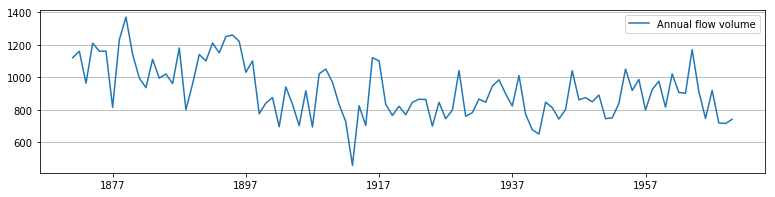

In [4]:
# This dataset is available in Statsmodels
nile = sm.datasets.nile.load_pandas().data['volume']
nile.index = pd.date_range('1871', '1970', freq='AS')

# Plot the series to see what it looks like
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
ax.plot(nile.index, nile, label='Annual flow volume')
ax.legend()
ax.yaxis.grid()

## State space model

The local level model is:

$$
\begin{align}
y_t & = \mu_t + \varepsilon_t, \qquad \varepsilon_t \sim N(0, \sigma_\varepsilon^2) \\
    \mu_{t+1} & = \mu_t + \eta_t, \qquad \eta_t \sim N(0, \sigma_\eta^2) \\
\end{align}
$$

This is already in state space form. Below we construct a custom class, `MLELocalLevel`, to estimate the local level model.

In [6]:
class MLELocalLevel(sm.tsa.statespace.MLEModel):
    start_params = [1.0, 1.0]
    param_names = ['obs.var', 'level.var']

    def __init__(self, endog):
        super(MLELocalLevel, self).__init__(endog, k_states=1)

        self['design', 0, 0] = 1.0
        self['transition', 0, 0] = 1.0
        self['selection', 0, 0] = 1.0

        self.initialize_approximate_diffuse()
        self.loglikelihood_burn = 1

    def transform_params(self, params):
        return params**2

    def untransform_params(self, params):
        return params**0.5

    def update(self, params, **kwargs):
        # Transform the parameters if they are not yet transformed
        params = super(MLELocalLevel, self).update(params, **kwargs)

        self['obs_cov', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[1]

## Maximum likelihood estimation

With this class, we can instantiate a new object with the Nile data and fit the model by maximum likelihood methods.

In [7]:
nile_model = MLELocalLevel(nile)
nile_results = nile_model.fit()

print(nile_results.summary())

                           Statespace Model Results                           
Dep. Variable:                 volume   No. Observations:                  100
Model:                  MLELocalLevel   Log Likelihood                -632.538
Date:                Sat, 28 Jan 2017   AIC                           1269.075
Time:                        10:26:43   BIC                           1274.286
Sample:                    01-01-1871   HQIC                          1271.184
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
obs.var     1.513e+04   2591.296      5.838      0.000       1e+04    2.02e+04
level.var   1461.2648    843.355      1.733      0.083    -191.681    3114.211
Ljung-Box (Q):                       36.00   Jarque-

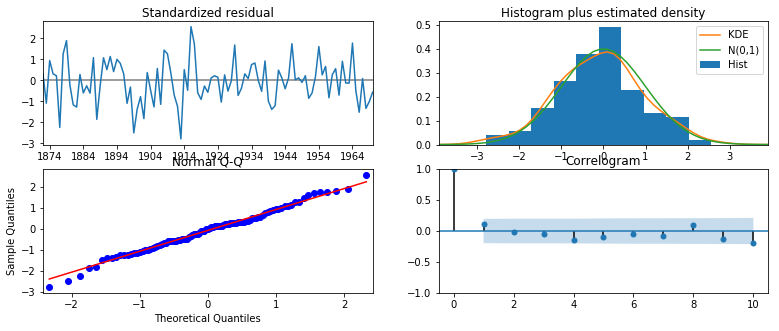

In [9]:
nile_results.plot_diagnostics(figsize=(13, 5));

This model appears to achieve a reasonably good fit. At this point, we can perform forecasting and compute impulse responses. Note that those two operations are not very informative for a local level model. The model will forecast the data to remain at whatever level it was last at, and impulse responses last forever.

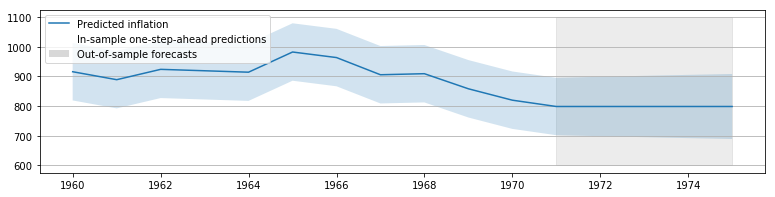

In [18]:
# Construct the predictions / forecasts
nile_forecast = nile_results.get_prediction(start='1960-01-01', end='1975-01-01')

# Plot them
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)

forecast = nile_forecast.predicted_mean
ci = nile_forecast.conf_int(alpha=0.5)

ax.fill_between(forecast.ix['1970-01-02':].index, 600, 1100, color='grey',
                alpha=0.15)
lines, = ax.plot(forecast.index, forecast)
ax.fill_between(forecast.index, ci['lower volume'], ci['upper volume'],
                alpha=0.2)

p1 = plt.Rectangle((0, 0), 1, 1, fc="white")
p2 = plt.Rectangle((0, 0), 1, 1, fc="grey", alpha=0.3)
ax.legend([lines, p1, p2], ["Predicted inflation",
                            "In-sample one-step-ahead predictions",
                            "Out-of-sample forecasts"], loc='upper left')
ax.yaxis.grid()

In [22]:
# Construct the impulse responses
nile_irfs = nile_results.impulse_responses(steps=10)

print(nile_irfs)

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
Name: volume, dtype: float64


## Local level in Statsmodels via UnobservedComponents

The large class of unobserved components (or structural time series models) is implemented in Statsmodels in the `sm.tsa.UnobservedComponents` class.

First, we'll check that fitting a local level model by maximum likelihood using `sm.tsa.UnobservedComponents` gives the same results as our `MLELocalLevel` class, above.

Here, notice that the parameter estimates are very slightly different, but the loglikelihood is the same.

In [23]:
nile_model2 = sm.tsa.UnobservedComponents(nile, 'local level')
nile_results2 = nile_model2.fit()

print(nile_results2.summary())

                        Unobserved Components Results                         
Dep. Variable:                 volume   No. Observations:                  100
Model:                    local level   Log Likelihood                -632.538
Date:                Sat, 28 Jan 2017   AIC                           1269.076
Time:                        10:33:10   BIC                           1274.286
Sample:                    01-01-1871   HQIC                          1271.184
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.508e+04   2586.506      5.829      0.000       1e+04    2.01e+04
sigma2.level      1478.8117    851.329      1.737      0.082    -189.762    3147.385
Ljung-Box (Q):              

One of the features of the built-in `UnobservedComponents` class is the ability to plot the various components.

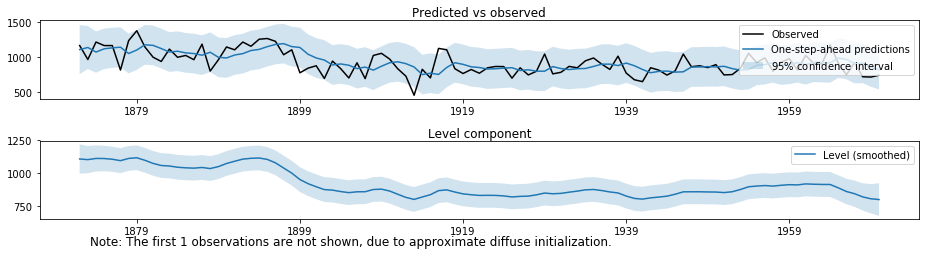

In [215]:
fig = nile_results2.plot_components(figsize=(13, 3.5))
fig.tight_layout()

## Metropolis-Hastings - Local level

Here we show how to estimate the local level model via Metropolis-Hastings using PyMC. Recall that the local level model has two parameters: $(\sigma_\varepsilon^2, \sigma_\eta^2)$.

For the associated prediction parameters $1 / \sigma^2$, we specify a $\Gamma(2, 4)$ prior.

In [26]:
import pymc as mc

# Priors
prior_eps = mc.Gamma('eps', 0.5, 1)
prior_eta = mc.Gamma('eta', 0.5, 1)

# Create the model for likelihood evaluation
model = sm.tsa.UnobservedComponents(nile, 'local level')

# Create the "data" component (stochastic and observed)
@mc.stochastic(dtype=sm.tsa.statespace.MLEModel, observed=True)
def loglikelihood(value=model, eps=prior_eps, eta=prior_eta):
    return value.loglike([1 / eps, 1 / eta])

# Create the PyMC model
pymc_model = mc.Model((prior_eps, prior_eta, loglikelihood))

# Create a PyMC sample and perform sampling
sampler = mc.MCMC(pymc_model)
sampler.sample(iter=10000, burn=1000, thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 7.3 sec

Plotting eps
Plotting eta


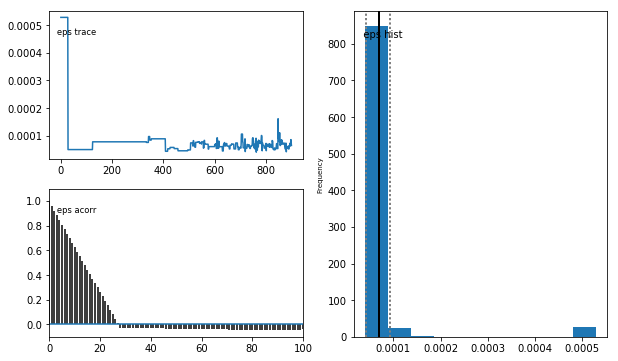

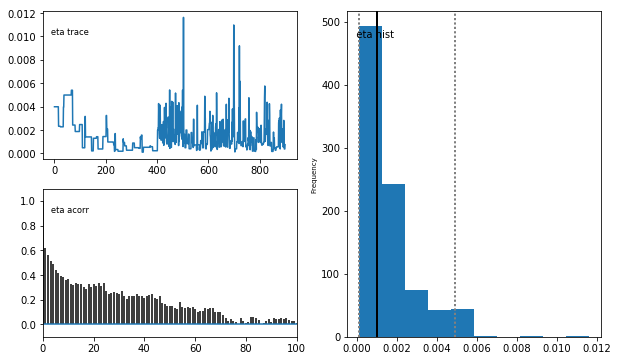

In [27]:
# Plot traces
mc.Matplot.plot(sampler)

Recall that these parameters are *precisions*, and we need to invert them to get the implied variances. The values are very close to those estimated by maximum likelihood.

In [37]:
print 'Mean sigma_eps^2 = ', (1 / sampler.trace('eps').gettrace()).mean()
print 'Mean sigma_eta^2 = ', (1 / sampler.trace('eta').gettrace()).mean()

Mean sigma_eps^2 =  15172.1835608
Mean sigma_eta^2 =  1497.97199417


## Gibbs Sampling - Local level

Here we show how to estimate the local level model via Gibbs Sampling. The key to doing this is noting that conditional on the states, the observation and transition equations provide a formula for $\varepsilon_t$ and $\eta_t$:

$$
\begin{align}
\varepsilon_t & = y_t - \mu_t \\
\eta_t & = \mu_{t+1} - \mu_t \\
\end{align}
$$

In order to apply Gibbs sampling, we select the conjugate inverse Gamma prior, specifically $IG(3, 3)$, for both variances.

$$
\begin{align}
p(x) & = \frac{1}{\Gamma(a)} x^{-a-1} e^{-1/x} \\
& \implies \frac{1}{\beta} \frac{1}{\Gamma(a)} (x / \beta)^{-a-1} e^{-1/(x / \beta)} \\
& = \beta^{-1} \beta^{a+1} \frac{1}{\Gamma(a)} x^{-a-1} e^{-\beta/x} \\
& = \frac{\beta^\alpha}{\Gamma(a)} x^{-a-1} e^{-\beta/x} \\
\end{align}
$$

In [201]:
from scipy.stats import invgamma

def draw_posterior_sigma2_eps(model, states):
    resid = model.endog[:, 0] - states[0]
    post_shape = len(resid)
    post_scale = np.sum(resid**2)

    return invgamma.rvs(post_shape, scale=post_scale)

def draw_posterior_sigma2_eta(model, states):
    resid = states[0, 1:] - states[0, :-1]
    post_shape = len(resid)
    post_scale = np.sum(resid**2)

    return invgamma.rvs(post_shape, scale=post_scale)

np.random.seed(17429)

# Create the model for likelihood evaluation and the simulation smoother
model = sm.tsa.UnobservedComponents(nile, 'local level')
sim_smoother = model.simulation_smoother()

# Create storage arrays for the traces
n_iterations = 10000
trace = np.zeros((n_iterations + 1, 2))
trace_accepts = np.zeros(n_iterations)
trace[0] = [15000., 1300.]  # Initial values

# Iterations
for s in range(1, n_iterations + 1):
    # 1. Gibbs step: draw the states using the simulation smoother
    model.update(trace[s-1], transformed=True)
    sim_smoother.simulate()
    states = sim_smoother.simulated_state

    # 2-3. Gibbs steps: draw the variance parameters
    sigma2_eps = draw_posterior_sigma2_eps(model, states)
    sigma2_eta = draw_posterior_sigma2_eta(model, states)
    trace[s] = [sigma2_eps, sigma2_eta]

# For analysis, burn the first 1000 observations, and only
# take every tenth remaining observation
burn = 1000
thin = 10
final_trace = trace[burn:][::thin]

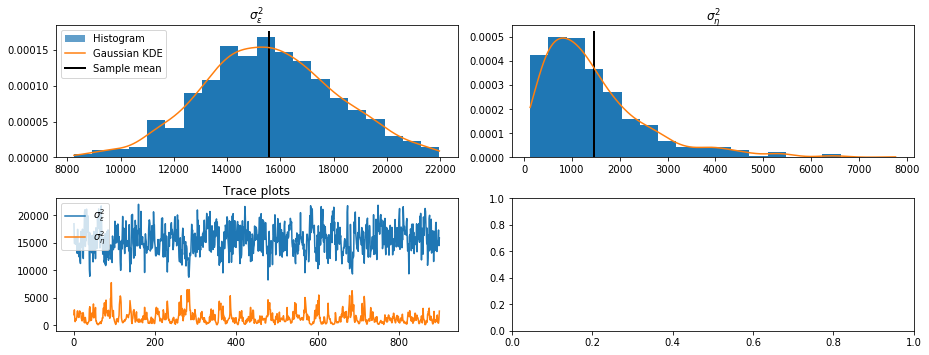

In [204]:
from scipy.stats import gaussian_kde

fig, axes = plt.subplots(2, 2, figsize=(13, 5), dpi=300)

sigma2_eps_kde = gaussian_kde(final_trace[:, 0])
sigma2_eta_kde = gaussian_kde(final_trace[:, 1])

axes[0, 0].hist(final_trace[:, 0], bins=20, normed=True, alpha=1)
X = np.linspace(np.min(final_trace[:, 0]), np.max(final_trace[:, 0]), 5000)
line, = axes[0, 0].plot(X, sigma2_eps_kde(X))
ylim = axes[0, 0].get_ylim()
vline = axes[0, 0].vlines(final_trace[:, 0].mean(), ylim[0], ylim[1],
                          linewidth=2)
axes[0, 0].set(title=r'$\sigma_\varepsilon^2$')

axes[0, 1].hist(final_trace[:, 1], bins=20, normed=True, alpha=1)
X = np.linspace(np.min(final_trace[:, 1]), np.max(final_trace[:, 1]), 5000)
axes[0, 1].plot(X, sigma2_eta_kde(X))
ylim = axes[0, 1].get_ylim()
vline = axes[0, 1].vlines(final_trace[:, 1].mean(), ylim[0], ylim[1],
                          linewidth=2)
axes[0, 1].set(title=r'$\sigma_\eta^2$')

p1 = plt.Rectangle((0, 0), 1, 1, alpha=0.7)
axes[0, 0].legend([p1, line, vline],
                  ["Histogram", "Gaussian KDE", "Sample mean"],
                  loc='upper left')

axes[1, 0].plot(final_trace[:, 0], label=r'$\sigma_\varepsilon^2$')
axes[1, 0].plot(final_trace[:, 1], label=r'$\sigma_\eta^2$')
axes[1, 0].legend(loc='upper left')
axes[1, 0].set(title=r'Trace plots')
fig.tight_layout()

## Expanded model: UnobservedComponents

We'll try a more complicated model now by adding a stochastic cycle to the local level. We'll estimate the model via maximum likelihood.

In [205]:
nile_model3 = sm.tsa.UnobservedComponents(nile, 'local level', cycle=True, stochastic_cycle=True)
nile_results3 = nile_model3.fit()

print(nile_results3.summary())

                        Unobserved Components Results                         
Dep. Variable:                 volume   No. Observations:                  100
Model:                    local level   Log Likelihood                -624.934
                   + stochastic cycle   AIC                           1257.868
Date:                Sat, 28 Jan 2017   BIC                           1268.289
Time:                        12:36:46   HQIC                          1262.086
Sample:                    01-01-1871                                         
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.462e+04   2910.491      5.023      0.000    8915.930    2.03e+04
sigma2.level       824.8473    496

We can see that the cycle component helps smooth out the level.

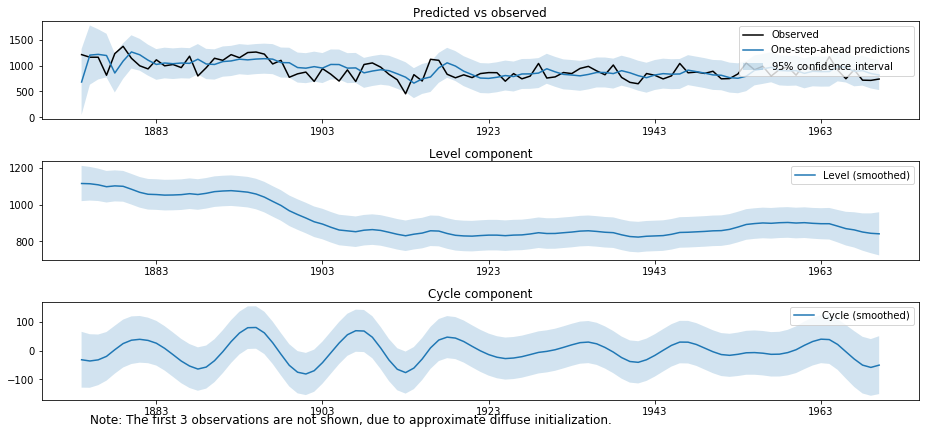

In [208]:
fig = nile_results3.plot_components(figsize=(13, 6))
fig.tight_layout()